# Inerpretation-Net Training

# Experiment 1: I-Net Performance for Different Algebras and Complexities
# Experiment 2: I-Net Performance Comparison for λ-Nets with Different Training Levels
# Experiment 3: I-Net Performance Comparison Different Training Data Sizes

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 80 #minutes


config = {
    'data': {
        'd': 5, #degree
        'n': 3, #number of variables
        'sparsity': None,
        'sample_sparsity': 5,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 10000,
        'noise': 0.25,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 1000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0.25,
        'epochs': 500,
        'early_stopping': True,
        'batch_size': 512,
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 10000,
                
        'interpretation_net_output_monomials': None, #(None, int)
        'interpretation_net_output_shape': None, #calculated automatically later
        
        'evaluate_with_real_function': False,
        'consider_labels_training': False,
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': True,
        'nas_type': 'SEQUENTIAL', #options:(None, 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 50,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 20,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
    },
    'computation':{
        'n_jobs': 11,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns


import tensorflow as tf
import random 


import warnings


from IPython.display import display, Math, Latex



In [4]:
sys.path.append('..')

from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *

In [5]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

In [6]:
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis

config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d'])
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else 2*config['i_net']['interpretation_net_output_monomials']


transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sparsity')*config['data']['sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [7]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense512-1024-output_56_drop0.25e500b512_custom/lnets_10000_280-1000eES64b_adam_mae_train_1000_diffX_1-FixSeed_42/var_3_d_5_sparsity_5_amin_-1_amax_1_xdist_uniform_noise_normal_0.25
lnets_10000_280-1000eES64b_adam_mae_train_1000_diffX_1-FixSeed_42/var_3_d_5_sparsity_5_amin_-1_amax_1_xmin_0_xmax_1_xdist_uniform_noise_normal_0.25


In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Utility functions

### Generate List of Monomial Identifiers

In [9]:
list_of_monomial_identifiers_extended = []
for i in tqdm(range((d+1)**n)):    
    monomial_identifier = dec_to_base(i, base = (d+1)).zfill(n) 
    list_of_monomial_identifiers_extended.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers_extended)

list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    monomial_identifier_values = list(map(int, list(monomial_identifier)))
    if sum(monomial_identifier_values) <= d:
        list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


layers_with_input_output = list(flatten([[n], lambda_network_layers, [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]

  0%|          | 0/216 [00:00<?, ?it/s]

List length: 216
Number of monomials in a polynomial with 3 variables and degree 5: 56
Sparsity: 56
['000', '001', '002', '003', '004', '005', '010', '011', '012', '013', '014', '015', '020', '021', '022', '023', '024', '025', '030', '031', '032', '033', '034', '035', '040', '041', '042', '043', '044', '045', '050', '051', '052', '053', '054', '055', '100', '101', '102', '103', '104', '105', '110', '111', '112', '113', '114', '115', '120', '121', '122', '123', '124', '125', '130', '131', '132', '133', '134', '135', '140', '141', '142', '143', '144', '145', '150', '151', '152', '153', '154', '155', '200', '201', '202', '203', '204', '205', '210', '211', '212', '213', '214', '215', '220', '221', '222', '223', '224', '225', '230', '231', '232', '233', '234', '235', '240', '241', '242', '243', '244', '245', '250', '251', '252', '253', '254', '255', '300', '301', '302', '303', '304', '305', '310', '311', '312', '313', '314', '315', '320', '321', '322', '323', '324', '325', '330', '331', '33

  0%|          | 0/216 [00:00<?, ?it/s]

List length: 56
Number of monomials in a polynomial with 3 variables and degree 5: 56
Sparsity: 56
['000', '001', '002', '003', '004', '005', '010', '011', '012', '013', '014', '020', '021', '022', '023', '030', '031', '032', '040', '041', '050', '100', '101', '102', '103', '104', '110', '111', '112', '113', '120', '121', '122', '130', '131', '140', '200', '201', '202', '203', '210', '211', '212', '220', '221', '230', '300', '301', '302', '310', '311', '320', '400', '401', '410', '500']


## Load Data and Generate Datasets

In [10]:
def load_lambda_nets(index):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path = './data/weights/' + 'weights_' + path_identifier_lambda_net_data + '/weights_' + '_epoch_' + str(index).zfill(3) + '.txt'

    
    weight_data = pd.read_csv(path, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)

    lambda_nets = []
    for _, row in weight_data.iterrows():
        lambda_net = LambdaNet(row.values)
        lambda_nets.append(lambda_net)
        
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [11]:
#LOAD DATA

parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=11)]: Using backend MultiprocessingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   1 out of   1 | elapsed:   24.4s finished


## Data Inspection

In [12]:
lambda_net_dataset.as_pandas().head()

,seed,000-target,001-target,002-target,003-target,004-target,005-target,010-target,011-target,012-target,013-target,014-target,020-target,021-target,022-target,023-target,030-target,031-target,032-target,040-target,041-target,050-target,100-target,101-target,102-target,103-target,104-target,110-target,111-target,112-target,113-target,120-target,121-target,122-target,130-target,131-target,140-target,200-target,201-target,202-target,203-target,210-target,211-target,212-target,220-target,221-target,230-target,300-target,301-target,302-target,310-target,311-target,320-target,400-target,401-target,410-target,500-target,000-lstsq_lambda,001-lstsq_lambda,002-lstsq_lambda,003-lstsq_lambda,004-lstsq_lambda,005-lstsq_lambda,010-lstsq_lambda,011-lstsq_lambda,012-lstsq_lambda,013-lstsq_lambda,014-lstsq_lambda,020-lstsq_lambda,021-lstsq_lambda,022-lstsq_lambda,023-lstsq_lambda,030-lstsq_lambda,031-lstsq_lambda,032-lstsq_lambda,040-lstsq_lambda,041-lstsq_lambda,050-lstsq_lambda,100-lstsq_lambda,101-lstsq_lambda,102-lstsq_lambda,103-lstsq_lambda,104-lstsq_lambda,110-lstsq_lambda,111-lstsq_lambda,112-lstsq_lambda,113-lstsq_lambda,120-lstsq_lambda,121-lstsq_lambda,122-lstsq_lambda,130-lstsq_lambda,131-lstsq_lambda,140-lstsq_lambda,200-lstsq_lambda,201-lstsq_lambda,202-lstsq_lambda,203-lstsq_lambda,210-lstsq_lambda,211-lstsq_lambda,212-lstsq_lambda,220-lstsq_lambda,221-lstsq_lambda,230-lstsq_lambda,300-lstsq_lambda,301-lstsq_lambda,302-lstsq_lambda,310-lstsq_lambda,311-lstsq_lambda,320-lstsq_lambda,400-lstsq_lambda,401-lstsq_lambda,410-lstsq_lambda,500-lstsq_lambda,000-lstsq_target,001-lstsq_target,002-lstsq_target,003-lstsq_target,004-lstsq_target,005-lstsq_target,010-lstsq_target,011-lstsq_target,012-lstsq_target,013-lstsq_target,014-lstsq_target,020-lstsq_target,021-lstsq_target,022-lstsq_target,023-lstsq_target,030-lstsq_target,031-lstsq_target,032-lstsq_target,040-lstsq_target,041-lstsq_target,050-lstsq_target,100-lstsq_target,101-lstsq_target,102-lstsq_target,103-lstsq_target,104-lstsq_target,110-lstsq_target,111-lstsq_target,112-lstsq_target,113-lstsq_target,120-lstsq_target,121-lstsq_target,122-lstsq_target,130-lstsq_target,131-lstsq_target,140-lstsq_target,200-lstsq_target,201-lstsq_target,202-lstsq_target,203-lstsq_target,210-lstsq_target,211-lstsq_target,212-lstsq_target,220-lstsq_target,221-lstsq_target,230-lstsq_target,300-lstsq_target,301-lstsq_target,302-lstsq_target,310-lstsq_target,311-lstsq_target,320-lstsq_target,400-lstsq_target,401-lstsq_target,410-lstsq_target,500-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,...,wb_1151,wb_1152,wb_1153,wb_1154,wb_1155,wb_1156,wb_1157,wb_1158,wb_1159,wb_1160,wb_1161,wb_1162,wb_1163,wb_1164,wb_1165,wb_1166,wb_1167,wb_1168,wb_1169,wb_1170,wb_1171,wb_1172,wb_1173,wb_1174,wb_1175,wb_1176,wb_1177,wb_1178,wb_1179,wb_1180,wb_1181,wb_1182,wb_1183,wb_1184,wb_1185,wb_1186,wb_1187,wb_1188,wb_1189,wb_1190,wb_1191,wb_1192,wb_1193,wb_1194,wb_1195,wb_1196,wb_1197,wb_1198,wb_1199,wb_1200,wb_1201,wb_1202,wb_1203,wb_1204,wb_1205,wb_1206,wb_1207,wb_1208,wb_1209,wb_1210,wb_1211,wb_1212,wb_1213,wb_1214,wb_1215,wb_1216,wb_1217,wb_1218,wb_1219,wb_1220,wb_1221,wb_1222,wb_1223,wb_1224,wb_1225,wb_1226,wb_1227,wb_1228,wb_1229,wb_1230,wb_1231,wb_1232,wb_1233,wb_1234,wb_1235,wb_1236,wb_1237,wb_1238,wb_1239,wb_1240,wb_1241,wb_1242,wb_1243,wb_1244,wb_1245,wb_1246,wb_1247,wb_1248,wb_1249,wb_1250,wb_1251,wb_1252,wb_1253,wb_1254,wb_1255,wb_1256,wb_1257,wb_1258,wb_1259,wb_1260,wb_1261,wb_1262,wb_1263,wb_1264,wb_1265,wb_1266,wb_1267,wb_1268,wb_1269,wb_1270,wb_1271,wb_1272,wb_1273,wb_1274,wb

In [13]:
lambda_net_dataset.as_pandas().describe()

,seed,000-target,001-target,002-target,003-target,004-target,005-target,010-target,011-target,012-target,013-target,014-target,020-target,021-target,022-target,023-target,030-target,031-target,032-target,040-target,041-target,050-target,100-target,101-target,102-target,103-target,104-target,110-target,111-target,112-target,113-target,120-target,121-target,122-target,130-target,131-target,140-target,200-target,201-target,202-target,203-target,210-target,211-target,212-target,220-target,221-target,230-target,300-target,301-target,302-target,310-target,311-target,320-target,400-target,401-target,410-target,500-target,000-lstsq_lambda,001-lstsq_lambda,002-lstsq_lambda,003-lstsq_lambda,004-lstsq_lambda,005-lstsq_lambda,010-lstsq_lambda,011-lstsq_lambda,012-lstsq_lambda,013-lstsq_lambda,014-lstsq_lambda,020-lstsq_lambda,021-lstsq_lambda,022-lstsq_lambda,023-lstsq_lambda,030-lstsq_lambda,031-lstsq_lambda,032-lstsq_lambda,040-lstsq_lambda,041-lstsq_lambda,050-lstsq_lambda,100-lstsq_lambda,101-lstsq_lambda,102-lstsq_lambda,103-lstsq_lambda,104-lstsq_lambda,110-lstsq_lambda,111-lstsq_lambda,112-lstsq_lambda,113-lstsq_lambda,120-lstsq_lambda,121-lstsq_lambda,122-lstsq_lambda,130-lstsq_lambda,131-lstsq_lambda,140-lstsq_lambda,200-lstsq_lambda,201-lstsq_lambda,202-lstsq_lambda,203-lstsq_lambda,210-lstsq_lambda,211-lstsq_lambda,212-lstsq_lambda,220-lstsq_lambda,221-lstsq_lambda,230-lstsq_lambda,300-lstsq_lambda,301-lstsq_lambda,302-lstsq_lambda,310-lstsq_lambda,311-lstsq_lambda,320-lstsq_lambda,400-lstsq_lambda,401-lstsq_lambda,410-lstsq_lambda,500-lstsq_lambda,000-lstsq_target,001-lstsq_target,002-lstsq_target,003-lstsq_target,004-lstsq_target,005-lstsq_target,010-lstsq_target,011-lstsq_target,012-lstsq_target,013-lstsq_target,014-lstsq_target,020-lstsq_target,021-lstsq_target,022-lstsq_target,023-lstsq_target,030-lstsq_target,031-lstsq_target,032-lstsq_target,040-lstsq_target,041-lstsq_target,050-lstsq_target,100-lstsq_target,101-lstsq_target,102-lstsq_target,103-lstsq_target,104-lstsq_target,110-lstsq_target,111-lstsq_target,112-lstsq_target,113-lstsq_target,120-lstsq_target,121-lstsq_target,122-lstsq_target,130-lstsq_target,131-lstsq_target,140-lstsq_target,200-lstsq_target,201-lstsq_target,202-lstsq_target,203-lstsq_target,210-lstsq_target,211-lstsq_target,212-lstsq_target,220-lstsq_target,221-lstsq_target,230-lstsq_target,300-lstsq_target,301-lstsq_target,302-lstsq_target,310-lstsq_target,311-lstsq_target,320-lstsq_target,400-lstsq_target,401-lstsq_target,410-lstsq_target,500-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,...,wb_1151,wb_1152,wb_1153,wb_1154,wb_1155,wb_1156,wb_1157,wb_1158,wb_1159,wb_1160,wb_1161,wb_1162,wb_1163,wb_1164,wb_1165,wb_1166,wb_1167,wb_1168,wb_1169,wb_1170,wb_1171,wb_1172,wb_1173,wb_1174,wb_1175,wb_1176,wb_1177,wb_1178,wb_1179,wb_1180,wb_1181,wb_1182,wb_1183,wb_1184,wb_1185,wb_1186,wb_1187,wb_1188,wb_1189,wb_1190,wb_1191,wb_1192,wb_1193,wb_1194,wb_1195,wb_1196,wb_1197,wb_1198,wb_1199,wb_1200,wb_1201,wb_1202,wb_1203,wb_1204,wb_1205,wb_1206,wb_1207,wb_1208,wb_1209,wb_1210,wb_1211,wb_1212,wb_1213,wb_1214,wb_1215,wb_1216,wb_1217,wb_1218,wb_1219,wb_1220,wb_1221,wb_1222,wb_1223,wb_1224,wb_1225,wb_1226,wb_1227,wb_1228,wb_1229,wb_1230,wb_1231,wb_1232,wb_1233,wb_1234,wb_1235,wb_1236,wb_1237,wb_1238,wb_1239,wb_1240,wb_1241,wb_1242,wb_1243,wb_1244,wb_1245,wb_1246,wb_1247,wb_1248,wb_1249,wb_1250,wb_1251,wb_1252,wb_1253,wb_1254,wb_1255,wb_1256,wb_1257,wb_1258,wb_1259,wb_1260,wb_1261,wb_1262,wb_1263,wb_1264,wb_1265,wb_1266,wb_1267,wb_1268,wb_1269,wb_1270,wb_1271,wb_1272,wb_1273,wb_1274,wb

## Generate Datasets for Interpretation-Net training

In [14]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []

for lambda_net_dataset in lambda_net_dataset_list:
    
    
    if inet_holdout_seed_evaluation:
        complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

        random.seed(RANDOM_SEED)
        test_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)
        
        random.seed(RANDOM_SEED)
        valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

        train_seeds = complete_seed_list
        lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       
        
        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
        
        del lambda_net_dataset
    else:
        lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=0.1)
        lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
    
        del lambda_net_dataset, lambda_net_train_with_valid_dataset

        
del lambda_net_dataset_list

In [15]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(8100, 1570)

In [16]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(900, 1570)

In [17]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(1000, 1570)

In [18]:
lambda_net_train_dataset_list[-1].as_pandas().head()

,seed,000-target,001-target,002-target,003-target,004-target,005-target,010-target,011-target,012-target,013-target,014-target,020-target,021-target,022-target,023-target,030-target,031-target,032-target,040-target,041-target,050-target,100-target,101-target,102-target,103-target,104-target,110-target,111-target,112-target,113-target,120-target,121-target,122-target,130-target,131-target,140-target,200-target,201-target,202-target,203-target,210-target,211-target,212-target,220-target,221-target,230-target,300-target,301-target,302-target,310-target,311-target,320-target,400-target,401-target,410-target,500-target,000-lstsq_lambda,001-lstsq_lambda,002-lstsq_lambda,003-lstsq_lambda,004-lstsq_lambda,005-lstsq_lambda,010-lstsq_lambda,011-lstsq_lambda,012-lstsq_lambda,013-lstsq_lambda,014-lstsq_lambda,020-lstsq_lambda,021-lstsq_lambda,022-lstsq_lambda,023-lstsq_lambda,030-lstsq_lambda,031-lstsq_lambda,032-lstsq_lambda,040-lstsq_lambda,041-lstsq_lambda,050-lstsq_lambda,100-lstsq_lambda,101-lstsq_lambda,102-lstsq_lambda,103-lstsq_lambda,104-lstsq_lambda,110-lstsq_lambda,111-lstsq_lambda,112-lstsq_lambda,113-lstsq_lambda,120-lstsq_lambda,121-lstsq_lambda,122-lstsq_lambda,130-lstsq_lambda,131-lstsq_lambda,140-lstsq_lambda,200-lstsq_lambda,201-lstsq_lambda,202-lstsq_lambda,203-lstsq_lambda,210-lstsq_lambda,211-lstsq_lambda,212-lstsq_lambda,220-lstsq_lambda,221-lstsq_lambda,230-lstsq_lambda,300-lstsq_lambda,301-lstsq_lambda,302-lstsq_lambda,310-lstsq_lambda,311-lstsq_lambda,320-lstsq_lambda,400-lstsq_lambda,401-lstsq_lambda,410-lstsq_lambda,500-lstsq_lambda,000-lstsq_target,001-lstsq_target,002-lstsq_target,003-lstsq_target,004-lstsq_target,005-lstsq_target,010-lstsq_target,011-lstsq_target,012-lstsq_target,013-lstsq_target,014-lstsq_target,020-lstsq_target,021-lstsq_target,022-lstsq_target,023-lstsq_target,030-lstsq_target,031-lstsq_target,032-lstsq_target,040-lstsq_target,041-lstsq_target,050-lstsq_target,100-lstsq_target,101-lstsq_target,102-lstsq_target,103-lstsq_target,104-lstsq_target,110-lstsq_target,111-lstsq_target,112-lstsq_target,113-lstsq_target,120-lstsq_target,121-lstsq_target,122-lstsq_target,130-lstsq_target,131-lstsq_target,140-lstsq_target,200-lstsq_target,201-lstsq_target,202-lstsq_target,203-lstsq_target,210-lstsq_target,211-lstsq_target,212-lstsq_target,220-lstsq_target,221-lstsq_target,230-lstsq_target,300-lstsq_target,301-lstsq_target,302-lstsq_target,310-lstsq_target,311-lstsq_target,320-lstsq_target,400-lstsq_target,401-lstsq_target,410-lstsq_target,500-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,...,wb_1151,wb_1152,wb_1153,wb_1154,wb_1155,wb_1156,wb_1157,wb_1158,wb_1159,wb_1160,wb_1161,wb_1162,wb_1163,wb_1164,wb_1165,wb_1166,wb_1167,wb_1168,wb_1169,wb_1170,wb_1171,wb_1172,wb_1173,wb_1174,wb_1175,wb_1176,wb_1177,wb_1178,wb_1179,wb_1180,wb_1181,wb_1182,wb_1183,wb_1184,wb_1185,wb_1186,wb_1187,wb_1188,wb_1189,wb_1190,wb_1191,wb_1192,wb_1193,wb_1194,wb_1195,wb_1196,wb_1197,wb_1198,wb_1199,wb_1200,wb_1201,wb_1202,wb_1203,wb_1204,wb_1205,wb_1206,wb_1207,wb_1208,wb_1209,wb_1210,wb_1211,wb_1212,wb_1213,wb_1214,wb_1215,wb_1216,wb_1217,wb_1218,wb_1219,wb_1220,wb_1221,wb_1222,wb_1223,wb_1224,wb_1225,wb_1226,wb_1227,wb_1228,wb_1229,wb_1230,wb_1231,wb_1232,wb_1233,wb_1234,wb_1235,wb_1236,wb_1237,wb_1238,wb_1239,wb_1240,wb_1241,wb_1242,wb_1243,wb_1244,wb_1245,wb_1246,wb_1247,wb_1248,wb_1249,wb_1250,wb_1251,wb_1252,wb_1253,wb_1254,wb_1255,wb_1256,wb_1257,wb_1258,wb_1259,wb_1260,wb_1261,wb_1262,wb_1263,wb_1264,wb_1265,wb_1266,wb_1267,wb_1268,wb_1269,wb_1270,wb_1271,wb_1272,wb_1273,wb_1274,wb

In [19]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

,seed,000-target,001-target,002-target,003-target,004-target,005-target,010-target,011-target,012-target,013-target,014-target,020-target,021-target,022-target,023-target,030-target,031-target,032-target,040-target,041-target,050-target,100-target,101-target,102-target,103-target,104-target,110-target,111-target,112-target,113-target,120-target,121-target,122-target,130-target,131-target,140-target,200-target,201-target,202-target,203-target,210-target,211-target,212-target,220-target,221-target,230-target,300-target,301-target,302-target,310-target,311-target,320-target,400-target,401-target,410-target,500-target,000-lstsq_lambda,001-lstsq_lambda,002-lstsq_lambda,003-lstsq_lambda,004-lstsq_lambda,005-lstsq_lambda,010-lstsq_lambda,011-lstsq_lambda,012-lstsq_lambda,013-lstsq_lambda,014-lstsq_lambda,020-lstsq_lambda,021-lstsq_lambda,022-lstsq_lambda,023-lstsq_lambda,030-lstsq_lambda,031-lstsq_lambda,032-lstsq_lambda,040-lstsq_lambda,041-lstsq_lambda,050-lstsq_lambda,100-lstsq_lambda,101-lstsq_lambda,102-lstsq_lambda,103-lstsq_lambda,104-lstsq_lambda,110-lstsq_lambda,111-lstsq_lambda,112-lstsq_lambda,113-lstsq_lambda,120-lstsq_lambda,121-lstsq_lambda,122-lstsq_lambda,130-lstsq_lambda,131-lstsq_lambda,140-lstsq_lambda,200-lstsq_lambda,201-lstsq_lambda,202-lstsq_lambda,203-lstsq_lambda,210-lstsq_lambda,211-lstsq_lambda,212-lstsq_lambda,220-lstsq_lambda,221-lstsq_lambda,230-lstsq_lambda,300-lstsq_lambda,301-lstsq_lambda,302-lstsq_lambda,310-lstsq_lambda,311-lstsq_lambda,320-lstsq_lambda,400-lstsq_lambda,401-lstsq_lambda,410-lstsq_lambda,500-lstsq_lambda,000-lstsq_target,001-lstsq_target,002-lstsq_target,003-lstsq_target,004-lstsq_target,005-lstsq_target,010-lstsq_target,011-lstsq_target,012-lstsq_target,013-lstsq_target,014-lstsq_target,020-lstsq_target,021-lstsq_target,022-lstsq_target,023-lstsq_target,030-lstsq_target,031-lstsq_target,032-lstsq_target,040-lstsq_target,041-lstsq_target,050-lstsq_target,100-lstsq_target,101-lstsq_target,102-lstsq_target,103-lstsq_target,104-lstsq_target,110-lstsq_target,111-lstsq_target,112-lstsq_target,113-lstsq_target,120-lstsq_target,121-lstsq_target,122-lstsq_target,130-lstsq_target,131-lstsq_target,140-lstsq_target,200-lstsq_target,201-lstsq_target,202-lstsq_target,203-lstsq_target,210-lstsq_target,211-lstsq_target,212-lstsq_target,220-lstsq_target,221-lstsq_target,230-lstsq_target,300-lstsq_target,301-lstsq_target,302-lstsq_target,310-lstsq_target,311-lstsq_target,320-lstsq_target,400-lstsq_target,401-lstsq_target,410-lstsq_target,500-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,...,wb_1151,wb_1152,wb_1153,wb_1154,wb_1155,wb_1156,wb_1157,wb_1158,wb_1159,wb_1160,wb_1161,wb_1162,wb_1163,wb_1164,wb_1165,wb_1166,wb_1167,wb_1168,wb_1169,wb_1170,wb_1171,wb_1172,wb_1173,wb_1174,wb_1175,wb_1176,wb_1177,wb_1178,wb_1179,wb_1180,wb_1181,wb_1182,wb_1183,wb_1184,wb_1185,wb_1186,wb_1187,wb_1188,wb_1189,wb_1190,wb_1191,wb_1192,wb_1193,wb_1194,wb_1195,wb_1196,wb_1197,wb_1198,wb_1199,wb_1200,wb_1201,wb_1202,wb_1203,wb_1204,wb_1205,wb_1206,wb_1207,wb_1208,wb_1209,wb_1210,wb_1211,wb_1212,wb_1213,wb_1214,wb_1215,wb_1216,wb_1217,wb_1218,wb_1219,wb_1220,wb_1221,wb_1222,wb_1223,wb_1224,wb_1225,wb_1226,wb_1227,wb_1228,wb_1229,wb_1230,wb_1231,wb_1232,wb_1233,wb_1234,wb_1235,wb_1236,wb_1237,wb_1238,wb_1239,wb_1240,wb_1241,wb_1242,wb_1243,wb_1244,wb_1245,wb_1246,wb_1247,wb_1248,wb_1249,wb_1250,wb_1251,wb_1252,wb_1253,wb_1254,wb_1255,wb_1256,wb_1257,wb_1258,wb_1259,wb_1260,wb_1261,wb_1262,wb_1263,wb_1264,wb_1265,wb_1266,wb_1267,wb_1268,wb_1269,wb_1270,wb_1271,wb_1272,wb_1273,wb_1274,wb

In [20]:
lambda_net_test_dataset_list[-1].as_pandas().head()

,seed,000-target,001-target,002-target,003-target,004-target,005-target,010-target,011-target,012-target,013-target,014-target,020-target,021-target,022-target,023-target,030-target,031-target,032-target,040-target,041-target,050-target,100-target,101-target,102-target,103-target,104-target,110-target,111-target,112-target,113-target,120-target,121-target,122-target,130-target,131-target,140-target,200-target,201-target,202-target,203-target,210-target,211-target,212-target,220-target,221-target,230-target,300-target,301-target,302-target,310-target,311-target,320-target,400-target,401-target,410-target,500-target,000-lstsq_lambda,001-lstsq_lambda,002-lstsq_lambda,003-lstsq_lambda,004-lstsq_lambda,005-lstsq_lambda,010-lstsq_lambda,011-lstsq_lambda,012-lstsq_lambda,013-lstsq_lambda,014-lstsq_lambda,020-lstsq_lambda,021-lstsq_lambda,022-lstsq_lambda,023-lstsq_lambda,030-lstsq_lambda,031-lstsq_lambda,032-lstsq_lambda,040-lstsq_lambda,041-lstsq_lambda,050-lstsq_lambda,100-lstsq_lambda,101-lstsq_lambda,102-lstsq_lambda,103-lstsq_lambda,104-lstsq_lambda,110-lstsq_lambda,111-lstsq_lambda,112-lstsq_lambda,113-lstsq_lambda,120-lstsq_lambda,121-lstsq_lambda,122-lstsq_lambda,130-lstsq_lambda,131-lstsq_lambda,140-lstsq_lambda,200-lstsq_lambda,201-lstsq_lambda,202-lstsq_lambda,203-lstsq_lambda,210-lstsq_lambda,211-lstsq_lambda,212-lstsq_lambda,220-lstsq_lambda,221-lstsq_lambda,230-lstsq_lambda,300-lstsq_lambda,301-lstsq_lambda,302-lstsq_lambda,310-lstsq_lambda,311-lstsq_lambda,320-lstsq_lambda,400-lstsq_lambda,401-lstsq_lambda,410-lstsq_lambda,500-lstsq_lambda,000-lstsq_target,001-lstsq_target,002-lstsq_target,003-lstsq_target,004-lstsq_target,005-lstsq_target,010-lstsq_target,011-lstsq_target,012-lstsq_target,013-lstsq_target,014-lstsq_target,020-lstsq_target,021-lstsq_target,022-lstsq_target,023-lstsq_target,030-lstsq_target,031-lstsq_target,032-lstsq_target,040-lstsq_target,041-lstsq_target,050-lstsq_target,100-lstsq_target,101-lstsq_target,102-lstsq_target,103-lstsq_target,104-lstsq_target,110-lstsq_target,111-lstsq_target,112-lstsq_target,113-lstsq_target,120-lstsq_target,121-lstsq_target,122-lstsq_target,130-lstsq_target,131-lstsq_target,140-lstsq_target,200-lstsq_target,201-lstsq_target,202-lstsq_target,203-lstsq_target,210-lstsq_target,211-lstsq_target,212-lstsq_target,220-lstsq_target,221-lstsq_target,230-lstsq_target,300-lstsq_target,301-lstsq_target,302-lstsq_target,310-lstsq_target,311-lstsq_target,320-lstsq_target,400-lstsq_target,401-lstsq_target,410-lstsq_target,500-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,...,wb_1151,wb_1152,wb_1153,wb_1154,wb_1155,wb_1156,wb_1157,wb_1158,wb_1159,wb_1160,wb_1161,wb_1162,wb_1163,wb_1164,wb_1165,wb_1166,wb_1167,wb_1168,wb_1169,wb_1170,wb_1171,wb_1172,wb_1173,wb_1174,wb_1175,wb_1176,wb_1177,wb_1178,wb_1179,wb_1180,wb_1181,wb_1182,wb_1183,wb_1184,wb_1185,wb_1186,wb_1187,wb_1188,wb_1189,wb_1190,wb_1191,wb_1192,wb_1193,wb_1194,wb_1195,wb_1196,wb_1197,wb_1198,wb_1199,wb_1200,wb_1201,wb_1202,wb_1203,wb_1204,wb_1205,wb_1206,wb_1207,wb_1208,wb_1209,wb_1210,wb_1211,wb_1212,wb_1213,wb_1214,wb_1215,wb_1216,wb_1217,wb_1218,wb_1219,wb_1220,wb_1221,wb_1222,wb_1223,wb_1224,wb_1225,wb_1226,wb_1227,wb_1228,wb_1229,wb_1230,wb_1231,wb_1232,wb_1233,wb_1234,wb_1235,wb_1236,wb_1237,wb_1238,wb_1239,wb_1240,wb_1241,wb_1242,wb_1243,wb_1244,wb_1245,wb_1246,wb_1247,wb_1248,wb_1249,wb_1250,wb_1251,wb_1252,wb_1253,wb_1254,wb_1255,wb_1256,wb_1257,wb_1258,wb_1259,wb_1260,wb_1261,wb_1262,wb_1263,wb_1264,wb_1265,wb_1266,wb_1267,wb_1268,wb_1269,wb_1270,wb_1271,wb_1272,wb_1273,wb_1274,wb

## Interpretation Network Training

In [ ]:
(history_list, 
scores_list, 

function_values_complete_list, 
function_values_valid_list, 
function_values_test_list, 

inet_preds_list, 
inet_preds_valid_list, 
inet_preds_test_list, 

distrib_dict_list,
model_list) = calculate_interpretation_net_results(lambda_net_train_dataset_list, 
                                                   lambda_net_valid_dataset_list, 
                                                   lambda_net_test_dataset_list)

Trial 36 Complete [00h 14m 09s]
val_loss: 0.05355718359351158

Best val_loss So Far: 0.042279455810785294
Total elapsed time: 02h 15m 31s

Search: Running Trial #37

Hyperparameter    |Value             |Best Value So Far 
dense_block_1/u...|True              |True              
dense_block_1/n...|1                 |1                 
dense_block_1/u...|256               |256               
dense_block_1/d...|0.5               |0.5               
dense_block_1/u...|16                |32                
regression_head...|0                 |0                 
optimizer         |adam              |adam              
learning_rate     |1e-05             |1e-05             
dense_block_1/u...|256               |256               

Epoch 1/500
254/254 [==============================] - 7s 27ms/step - loss: 0.6508 - val_loss: 0.2378
Epoch 2/500
254/254 [==============================] - 5s 21ms/step - loss: 0.5538 - val_loss: 0.2141
Epoch 3/500
254/254 [==============================] - 5s 2

## Evaluate Interpretation Net

In [53]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 1
dense_block_1/units_0: 256
dense_block_1/dropout: 0.5
dense_block_1/units_1: 128
regression_head_1/dropout: 0.0
optimizer: adam
learning_rate: 0.0001
dense_block_1/units_2: 256
Score: 0.037625983357429504
None
Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 1
dense_block_1/units_0: 256
dense_block_1/dropout: 0.5
dense_block_1/units_1: 128
regression_head_1/dropout: 0.0
optimizer: adam_weight_decay
learning_rate: 0.0001
dense_block_1/units_2: 256
Score: 0.03827330842614174
None
Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 1
dense_block_1/units_0: 256
dense_block_1/dropout: 0.5
dense_block_1/units_1: 128
regression_head_1/dropout: 0.0
optimizer: adam
learning_rate: 1e-05
dense_block_1/units_2: 256
Score: 0.04058343172073364
None
Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_

In [54]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1401)]            0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 1401)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               358912    
_________________________________________________________________
re_lu (ReLU)                 (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
regression_head_1 (Dense)    (None, 1457)              374449    
Total params: 733,361
Trainable params: 733,361
Non-trainable params: 0
________________________________________________

In [55]:
scores_list[-1]

,MAE,RMSE,MAPE,Accuracy,Accuracy Multilabel,MAE FV,RMSE FV,MAPE FV,R2 FV,RAAE FV,RMAE FV,MEAN STD FV DIFF,MEAN FV1,MEAN FV2,STD FV1,STD FV2
inetPoly_VS_targetPoly_valid,0.113,0.192,4.359,0.424,0.000,0.057,0.083,2.564,0.601,0.371,1.815,0.077,0.015,0.014,0.348,0.393
inetPoly_VS_targetPoly_test,0.114,0.193,26.221,0.415,0.000,0.058,0.085,2.704,0.587,0.375,1.803,0.079,0.010,0.009,0.367,0.413
inetPoly_VS_predLambda_valid,NaN,NaN,NaN,NaN,NaN,0.039,0.048,1.758,0.897,0.228,0.599,0.041,0.015,0.015,0.348,0.384
inetPoly_VS_predLambda_test,NaN,NaN,NaN,NaN,NaN,0.040,0.050,2.520,0.893,0.232,0.609,0.041,0.010,0.009,0.367,0.404
inetPoly_VS_lstsqTarget_valid,1.138,1.865,97.959,0.056,0.000,0.038,0.048,1.736,0.899,0.225,0.616,0.040,0.015,0.015,0.348,0.384
inetPoly_VS_lstsqTarget_test,1.155,1.929,1348.970,0.056,0.000,0.040,0.049,2.368,0.894,0.229,0.632,0.041,0.010,0.009,0.367,0.404
inetPoly_VS_lstsqLambda_valid,1.138,1.865,97.959,0.056,0.000,0.038,0.048,1.736,0.899,0.225,0.616,0.040,0.015,0.015,0.348,0.384
inetPoly_VS_lstsqLambda_test,1.155,1.929,1348.970,0.056,0.000,0.040,0.049,2.368,0.894,0.229,0.632,0.041,0.010,0.009,0.367,0.404
lstsqLambda_VS_predLambda_valid,NaN,NaN,NaN,NaN,NaN,0.006,0.008,0.334,0.998,0.032,0.162,0.008,0.015,0.015,0.384,0.384
lstsqLambda_VS_predLambda_test,NaN,NaN,NaN,NaN,NaN,0.006,0.008,0.273,0.998,0.032,0.166,0.008,0.009,0.009,0.404,0.404


In [56]:
distrib_dict_list[-1]['MAE']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99,L-100,L-101,L-102,L-103,L-104,L-105,L-106,L-107,L-108,L-109,L-110,L-111,L-112,L-113,L-114,L-115,L-116,L-117,L-118,L-119,L-120,L-121,L-122,L-123,L-124,L-125,L-126,L-127,L-128,L-129,L-130,L-131,L-132,L-133,L-134,L-135,L-136,L-137,L-138,L-139,L-140,L-141,L-142,L-143,L-144,L-145,L-146,L-147,L-148,L-149,L-150,L-151,L-152,L-153,L-154,L-155,L-156,L-157,L-158,L-159,L-160,L-161,L-162,L-163,L-164,L-165,L-166,L-167,L-168,L-169,L-170,L-171,L-172,L-173,L-174,L-175,L-176,L-177,L-178,L-179,L-180,L-181,L-182,L-183,L-184,L-185,L-186,L-187,L-188,L-189,L-190,L-191,L-192,L-193,L-194,L-195,L-196,L-197,L-198,L-199,L-200,L-201,L-202,L-203,L-204,L-205,L-206,L-207,L-208,L-209,L-210,L-211,L-212,L-213,L-214,L-215,L-216,L-217,L-218,L-219,L-220,L-221,L-222,L-223,L-224,L-225,L-226,L-227,L-228,L-229,L-230,L-231,L-232,L-233,L-234,L-235,L-236,L-237,L-238,L-239,L-240,L-241,L-242,L-243,L-244,L-245,L-246,L-247,L-248,L-249,...,L-750,L-751,L-752,L-753,L-754,L-755,L-756,L-757,L-758,L-759,L-760,L-761,L-762,L-763,L-764,L-765,L-766,L-767,L-768,L-769,L-770,L-771,L-772,L-773,L-774,L-775,L-776,L-777,L-778,L-779,L-780,L-781,L-782,L-783,L-784,L-785,L-786,L-787,L-788,L-789,L-790,L-791,L-792,L-793,L-794,L-795,L-796,L-797,L-798,L-799,L-800,L-801,L-802,L-803,L-804,L-805,L-806,L-807,L-808,L-809,L-810,L-811,L-812,L-813,L-814,L-815,L-816,L-817,L-818,L-819,L-820,L-821,L-822,L-823,L-824,L-825,L-826,L-827,L-828,L-829,L-830,L-831,L-832,L-833,L-834,L-835,L-836,L-837,L-838,L-839,L-840,L-841,L-842,L-843,L-844,L-845,L-846,L-847,L-848,L-849,L-850,L-851,L-852,L-853,L-854,L-855,L-856,L-857,L-858,L-859,L-860,L-861,L-862,L-863,L-864,L-865,L-866,L-867,L-868,L-869,L-870,L-871,L-872,L-873,L-874,L-875,L-876,L-877,L-878,L-879,L-880,L-881,L-882,L-883,L-884,L-885,L-886,L-887,L-888,L-889,L-890,L-891,L-892,L-893,L-894,L-895,L-896,L-897,L-898,L-899,L-900,L-901,L-902,L-903,L-904,L-905,L-906,L-907,L-908,L-909,L-910,L-911,L-912,L-913,L-914,L-915,L-916,L-917,L-918,L-919,L-920,L-921,L-922,L-923,L-924,L-925,L-926,L-927,L-928,L-929,L-930,L-931,L-932,L-933,L-934,L-935,L-936,L-937,L-938,L-939,L-940,L-941,L-942,L-943,L-944,L-945,L-946,L-947,L-948,L-949,L-950,L-951,L-952,L-953,L-954,L-955,L-956,L-957,L-958,L-959,L-960,L-961,L-962,L-963,L-964,L-965,L-966,L-967,L-968,L-969,L-970,L-971,L-972,L-973,L-974,L-975,L-976,L-977,L-978,L-979,L-980,L-981,L-982,L-983,L-984,L-985,L-986,L-987,L-988,L-989,L-990,L-991,L-992,L-993,L-994,L-995,L-996,L-997,L-998,L-999
inetPoly_VS_targetPoly_valid,0.050,0.036,0.065,0.049,0.054,0.053,0.055,0.045,0.084,0.032,0.055,0.075,0.052,0.057,0.090,0.062,0.047,0.059,0.057,0.060,0.039,0.077,0.064,0.065,0.078,0.042,0.049,0.208,0.037,0.047,0.050,0.056,0.061,0.071,0.078,0.071,0.042,0.047,0.049,0.216,0.069,0.044,0.049,0.040,0.070,0.061,0.060,0.042,0.061,0.054,0.064,0.052,0.032,0.056,0.046,0.054,0.038,0.045,0.053,0.058,0.046,0.051,0.077,0.063,0.057,0.047,0.040,0.028,0.054,0.074,0.067,0.050,0.051,0.052,0.063,0.068,0.093,0.058,0.056,0.065,0.051,0.063,0.048,0.089,0.042,0.063,0.063,0.042,0.056,0.054,0.056,0.033,0.061,0.034,0.042,0.081,0.107,0.079,0.055,0.060,0.058,0.059,0.059,0.071,0.046,0.054,0.042,0.077,0.086,0.057,0.046,0.043,0.093,0.049,0.047,0.044,0.046,0.053,0.052,0.037,0.029,0.069,0.042,0.073,0.051,0.059,0.081,0.056,0.069,0.069,0.053,0.049,0.077,0.057,0.073,0.056,0.052,0.065,0.069,0.048,0.038,0.035,0.052,0.072,0.048,0.066,0.075,0.061,0.037,0.029,0.054,0.066,0.064,0.055,0.068,0.046,0.033,0.049,0.071,0.034,0.053,0.052,0.069,0.047,0.091,0.053,0.047,0.052,0.071,0.052,0.054,0.057,0.062,0.053,0.090,0.060,0.026,0.069,0.077,0.

In [57]:
distrib_dict_list[-1]['R2']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99,L-100,L-101,L-102,L-103,L-104,L-105,L-106,L-107,L-108,L-109,L-110,L-111,L-112,L-113,L-114,L-115,L-116,L-117,L-118,L-119,L-120,L-121,L-122,L-123,L-124,L-125,L-126,L-127,L-128,L-129,L-130,L-131,L-132,L-133,L-134,L-135,L-136,L-137,L-138,L-139,L-140,L-141,L-142,L-143,L-144,L-145,L-146,L-147,L-148,L-149,L-150,L-151,L-152,L-153,L-154,L-155,L-156,L-157,L-158,L-159,L-160,L-161,L-162,L-163,L-164,L-165,L-166,L-167,L-168,L-169,L-170,L-171,L-172,L-173,L-174,L-175,L-176,L-177,L-178,L-179,L-180,L-181,L-182,L-183,L-184,L-185,L-186,L-187,L-188,L-189,L-190,L-191,L-192,L-193,L-194,L-195,L-196,L-197,L-198,L-199,L-200,L-201,L-202,L-203,L-204,L-205,L-206,L-207,L-208,L-209,L-210,L-211,L-212,L-213,L-214,L-215,L-216,L-217,L-218,L-219,L-220,L-221,L-222,L-223,L-224,L-225,L-226,L-227,L-228,L-229,L-230,L-231,L-232,L-233,L-234,L-235,L-236,L-237,L-238,L-239,L-240,L-241,L-242,L-243,L-244,L-245,L-246,L-247,L-248,L-249,...,L-750,L-751,L-752,L-753,L-754,L-755,L-756,L-757,L-758,L-759,L-760,L-761,L-762,L-763,L-764,L-765,L-766,L-767,L-768,L-769,L-770,L-771,L-772,L-773,L-774,L-775,L-776,L-777,L-778,L-779,L-780,L-781,L-782,L-783,L-784,L-785,L-786,L-787,L-788,L-789,L-790,L-791,L-792,L-793,L-794,L-795,L-796,L-797,L-798,L-799,L-800,L-801,L-802,L-803,L-804,L-805,L-806,L-807,L-808,L-809,L-810,L-811,L-812,L-813,L-814,L-815,L-816,L-817,L-818,L-819,L-820,L-821,L-822,L-823,L-824,L-825,L-826,L-827,L-828,L-829,L-830,L-831,L-832,L-833,L-834,L-835,L-836,L-837,L-838,L-839,L-840,L-841,L-842,L-843,L-844,L-845,L-846,L-847,L-848,L-849,L-850,L-851,L-852,L-853,L-854,L-855,L-856,L-857,L-858,L-859,L-860,L-861,L-862,L-863,L-864,L-865,L-866,L-867,L-868,L-869,L-870,L-871,L-872,L-873,L-874,L-875,L-876,L-877,L-878,L-879,L-880,L-881,L-882,L-883,L-884,L-885,L-886,L-887,L-888,L-889,L-890,L-891,L-892,L-893,L-894,L-895,L-896,L-897,L-898,L-899,L-900,L-901,L-902,L-903,L-904,L-905,L-906,L-907,L-908,L-909,L-910,L-911,L-912,L-913,L-914,L-915,L-916,L-917,L-918,L-919,L-920,L-921,L-922,L-923,L-924,L-925,L-926,L-927,L-928,L-929,L-930,L-931,L-932,L-933,L-934,L-935,L-936,L-937,L-938,L-939,L-940,L-941,L-942,L-943,L-944,L-945,L-946,L-947,L-948,L-949,L-950,L-951,L-952,L-953,L-954,L-955,L-956,L-957,L-958,L-959,L-960,L-961,L-962,L-963,L-964,L-965,L-966,L-967,L-968,L-969,L-970,L-971,L-972,L-973,L-974,L-975,L-976,L-977,L-978,L-979,L-980,L-981,L-982,L-983,L-984,L-985,L-986,L-987,L-988,L-989,L-990,L-991,L-992,L-993,L-994,L-995,L-996,L-997,L-998,L-999
inetPoly_VS_targetPoly_valid,0.654,0.925,0.912,0.241,0.922,0.771,0.661,0.442,0.567,0.955,0.975,0.713,0.715,0.253,0.933,0.877,0.849,0.905,0.756,0.781,0.792,-0.336,0.898,0.851,0.933,-2.361,-0.658,0.015,0.785,0.841,0.799,0.930,0.839,0.829,0.817,-0.521,0.693,0.927,0.667,-0.070,0.801,0.770,0.933,0.495,0.917,0.871,0.858,0.863,0.886,0.813,0.931,0.905,0.936,0.778,0.903,0.759,-0.530,0.596,0.721,0.888,-0.122,0.666,0.820,0.923,0.934,0.912,0.912,0.932,0.684,0.103,0.839,0.925,0.933,0.933,0.918,0.845,-0.082,0.625,0.579,0.533,0.695,0.893,0.692,0.899,0.871,0.911,0.881,0.960,0.724,0.522,0.841,-2.328,0.862,-1.590,0.766,0.880,0.897,0.795,0.688,0.937,0.789,-8.274,-0.036,0.761,0.798,0.901,0.716,0.514,0.928,0.700,0.771,0.542,0.860,0.785,0.791,-0.070,0.663,0.920,0.463,0.962,0.600,0.944,0.953,0.824,0.433,0.670,0.384,0.715,0.445,0.608,0.277,0.126,0.782,0.910,0.885,0.551,0.907,0.416,0.886,0.819,0.882,0.897,-0.795,0.674,0.213,0.643,0.859,0.934,0.899,0.330,0.939,0.607,0.255,0.610,0.610,0.166,0.277,-0.105,0.843,0.232,0.885,0.870,0.086,0.933,0.895,0.903,0.648,0.818,0.897,0.331,0.802,0.946,0.848,0.453,0.550,0.854,0.815

In [58]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
polynomial_inet = inet_preds_test_list[-1][index_min]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_min])

print_polynomial_from_coefficients(polynomial_inet)

0.6086073366116842


-0.216289967298508*a**1.0*b**1.0*c**1.0 - 0.070148378610611*a**1.0*b**1.0*c**2.0 + 0.0973207503557205*a**1.0*b**1.0*c**3.0 - 0.048675213009119*a**1.0*b**1.0 - 0.0892916545271873*a**1.0*b**2.0*c**1.0 + 0.00385904079303145*a**1.0*b**2.0*c**2.0 + 0.0921719893813133*a**1.0*b**2.0 + 0.0176021866500378*a**1.0*b**3.0*c**1.0 + 0.111835196614265*a**1.0*b**3.0 - 0.00333197601139545*a**1.0*b**4.0 + 0.0501986891031265*a**1.0*c**1.0 + 0.0361285991966724*a**1.0*c**2.0 - 0.0411294847726822*a**1.0*c**3.0 + 0.00634079659357667*a**1.0*c**4.0 + 0.0127635905519128*a**1.0 - 0.0477601028978825*a**2.0*b**1.0*c**1.0 + 0.0958197712898254*a**2.0*b**1.0*c**2.0 - 0.0995502173900604*a**2.0*b**1.0 - 0.0337648540735245*a**2.0*b**2.0*c**1.0 - 0.0852146744728088*a**2.0*b**2.0 - 0.0953896194696426*a**2.0*b**3.0 + 0.0919844880700111*a**2.0*c**1.0 - 0.0181290321052074*a**2.0*c**2.0 - 0.130206808447838*a**2.0*c**3.0 + 0.110797375440598*a**2.0 + 0.12929505109787*a**3.0*b**1.0*c**1.0 + 0.0649990290403366*a**3.0*b**1.0 - 0.0

In [59]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.6520621741837398


-2.3246949861196*a**1.0*b**1.0*c**1.0 + 1.75864245992978*a**1.0*b**1.0*c**2.0 + 0.188165168140557*a**1.0*b**1.0*c**3.0 + 0.13618311285909*a**1.0*b**1.0 - 1.25638809898584*a**1.0*b**2.0*c**1.0 + 0.880474263537688*a**1.0*b**2.0*c**2.0 - 0.0460740378083529*a**1.0*b**2.0 - 1.02910395319056*a**1.0*b**3.0*c**1.0 + 2.75463413608868*a**1.0*b**3.0 - 0.912648262534736*a**1.0*b**4.0 - 0.36420997023699*a**1.0*c**1.0 - 1.42949880227816*a**1.0*c**2.0 + 1.08162468523019*a**1.0*c**3.0 + 0.900220541378399*a**1.0*c**4.0 + 0.0872530268420707*a**1.0 + 1.90090667156771*a**2.0*b**1.0*c**1.0 - 3.19861851483513*a**2.0*b**1.0*c**2.0 - 1.56028853163562*a**2.0*b**1.0 + 1.21097318161881*a**2.0*b**2.0*c**1.0 - 2.60126415799565*a**2.0*b**2.0 + 1.20185318948993*a**2.0*b**3.0 + 3.38087048491421*a**2.0*c**1.0 - 2.67222531399589*a**2.0*c**2.0 - 2.62967284513528*a**2.0*c**3.0 + 0.279807970829099*a**2.0 + 1.18900238222132*a**3.0*b**1.0*c**1.0 + 3.81690526766202*a**3.0*b**1.0 - 1.06506718384926*a**3.0*b**2.0 - 0.279773337

In [60]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

-0.975128496738263*a**1.0*b**1.0*c**2.0 - 0.390137742618782*a**1.0*b**2.0 + 0.476331883037201*a**1.0*b**4.0 + 0.318927325978347*a**2.0*b**1.0 + 0.352643248259088*a**3.0*c**2.0

In [61]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
polynomial_inet = inet_preds_test_list[-1][index_max]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_max])

print_polynomial_from_coefficients(polynomial_inet)

0.8175327455986778


-0.208155542612076*a**1.0*b**1.0*c**1.0 - 0.173715531826019*a**1.0*b**1.0*c**2.0 + 0.151908442378044*a**1.0*b**1.0*c**3.0 - 0.00350688770413399*a**1.0*b**1.0 - 0.0595147050917149*a**1.0*b**2.0*c**1.0 - 0.0448443740606308*a**1.0*b**2.0*c**2.0 + 0.16487692296505*a**1.0*b**2.0 + 0.238485440611839*a**1.0*b**3.0*c**1.0 + 0.0339515395462513*a**1.0*b**3.0 + 0.0607230737805367*a**1.0*b**4.0 - 0.246227264404297*a**1.0*c**1.0 - 0.214707568287849*a**1.0*c**2.0 + 0.169137388467789*a**1.0*c**3.0 + 0.209512978792191*a**1.0*c**4.0 - 0.464277416467667*a**1.0 - 0.117741525173187*a**2.0*b**1.0*c**1.0 + 0.199431359767914*a**2.0*b**1.0*c**2.0 - 0.180178806185722*a**2.0*b**1.0 - 0.060072660446167*a**2.0*b**2.0*c**1.0 - 0.0840451121330261*a**2.0*b**2.0 + 0.0514159053564072*a**2.0*b**3.0 - 0.0134353935718536*a**2.0*c**1.0 - 0.022465355694294*a**2.0*c**2.0 - 0.180670768022537*a**2.0*c**3.0 - 0.36671781539917*a**2.0 + 0.0235620327293873*a**3.0*b**1.0*c**1.0 + 0.15145443379879*a**3.0*b**1.0 - 0.283686816692352*

In [62]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_max])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.9102930882035902


-2.34026853109436*a**1.0*b**1.0*c**1.0 + 0.862853207618474*a**1.0*b**1.0*c**2.0 - 0.414934830165732*a**1.0*b**1.0*c**3.0 + 0.800139029277442*a**1.0*b**1.0 + 0.251697921225355*a**1.0*b**2.0*c**1.0 - 0.0037880743865557*a**1.0*b**2.0*c**2.0 + 0.729934411347331*a**1.0*b**2.0 + 0.33530582359866*a**1.0*b**3.0*c**1.0 - 0.776713251509901*a**1.0*b**3.0 + 0.129717511509335*a**1.0*b**4.0 - 0.894581363886441*a**1.0*c**1.0 + 2.07424445386289*a**1.0*c**2.0 - 1.58546459101753*a**1.0*c**3.0 + 0.547065819447697*a**1.0*c**4.0 - 0.747531496556499*a**1.0 + 2.26144197689371*a**2.0*b**1.0*c**1.0 + 0.0678939067841539*a**2.0*b**1.0*c**2.0 - 0.358795520290741*a**2.0*b**1.0 - 0.841949226430584*a**2.0*b**2.0*c**1.0 + 0.363232677979094*a**2.0*b**2.0 + 0.265859736482852*a**2.0*b**3.0 + 1.33797778604324*a**2.0*c**1.0 - 1.46216720735883*a**2.0*c**2.0 + 0.55991265000599*a**2.0*c**3.0 - 1.66512694117679*a**2.0 - 0.532326744261139*a**3.0*b**1.0*c**1.0 - 1.58572462977748*a**3.0*b**1.0 - 0.360399499774019*a**3.0*b**2.0 -

In [63]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

-0.237422585249553*a**2.0*b**1.0*c**2.0 - 0.948534481170684*a**2.0*c**2.0 - 0.974875902274615*a**2.0 - 0.290353654053735*b**1.0*c**1.0 - 0.645961830203505*c**1.0

In [64]:
r2_values_inet = distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: 0.587441257597438 (1000 Samples)
Mean (only positive): 0.7494576530523858 (918 Samples)


In [65]:
r2_values_lstsq_lambda = distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: 0.7543847074520579 (1000 Samples)
Mean (only positive): 0.8135770154065272 (964 Samples)


<AxesSubplot:xlabel='inetPoly_VS_targetPoly_test', ylabel='Count'>

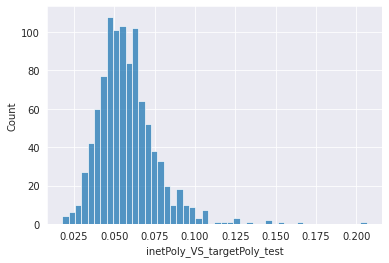

In [66]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50])


<AxesSubplot:xlabel='lstsqLambda_VS_targetPoly_test', ylabel='Count'>

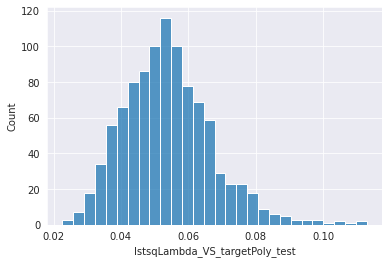

In [67]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50])


[(-30.0, 1.0)]

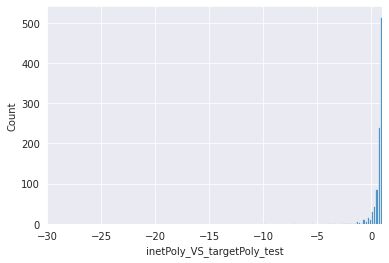

In [68]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50], binwidth=0.2)
p.set(xlim=(-30, 1))

[(0.0, 1.0)]

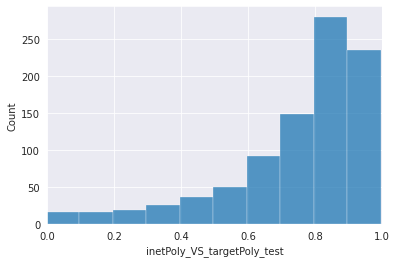

In [69]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

[(-10.0, 1.0)]

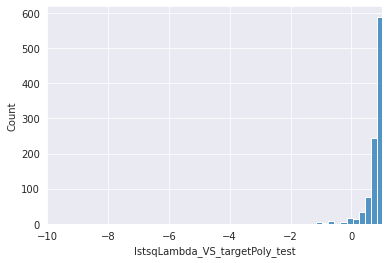

In [70]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50], binwidth=0.2)
p.set(xlim=(-10, 1))

[(0.0, 1.0)]

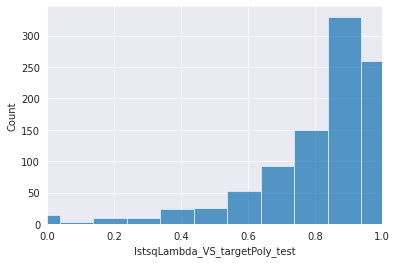

In [71]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

In [72]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + path_identifier_interpretation_net_data + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


In [73]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + path_identifier_interpretation_net_data + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [74]:
if len(scores_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list)

In [75]:
if len(scores_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list)

In [76]:
if len(scores_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [77]:
index = 5

polynomial_target = lambda_net_test_dataset.target_polynomial_list[index]
polynomial_lstsq_target = lambda_net_test_dataset.lstsq_target_polynomial_list[index]
polynomial_lstsq_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index]
polynomial_inet = inet_preds_test_list[-1][index]

print('Target Poly:')
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True, round_digits=4)
print('LSTSQ Target Poly:')
print_polynomial_from_coefficients(polynomial_lstsq_target, force_complete_poly_representation=True, round_digits=4)
print('LSTSQ Lambda Poly:')
print_polynomial_from_coefficients(polynomial_lstsq_lambda, force_complete_poly_representation=True, round_digits=4)
print('I-Net Poly:')
print_polynomial_from_coefficients(polynomial_inet, round_digits=4)


Target Poly:


0.2147*a**1.0*b**1.0 + 0.0696*a**3.0*b**1.0 + 0.6333*a**3.0 + 0.6953*b**4.0*c**1.0 - 0.0086*b**4.0

LSTSQ Target Poly:


-1.4958*a**1.0*b**1.0*c**1.0 + 1.1761*a**1.0*b**1.0*c**2.0 + 0.4353*a**1.0*b**1.0*c**3.0 - 0.4174*a**1.0*b**1.0 + 1.589*a**1.0*b**2.0*c**1.0 - 2.576*a**1.0*b**2.0*c**2.0 - 0.9199*a**1.0*b**2.0 + 0.5241*a**1.0*b**3.0*c**1.0 + 3.5115*a**1.0*b**3.0 - 2.0544*a**1.0*b**4.0 - 0.1857*a**1.0*c**1.0 + 1.9835*a**1.0*c**2.0 - 2.0142*a**1.0*c**3.0 + 0.6608*a**1.0*c**4.0 + 0.4108*a**1.0 + 0.3189*a**2.0*b**1.0*c**1.0 + 0.8678*a**2.0*b**1.0*c**2.0 + 2.2217*a**2.0*b**1.0 + 0.6065*a**2.0*b**2.0*c**1.0 - 2.1616*a**2.0*b**2.0 - 0.0391*a**2.0*b**3.0 - 1.8702*a**2.0*c**1.0 - 0.6847*a**2.0*c**2.0 + 0.0318*a**2.0*c**3.0 - 1.2507*a**2.0 - 1.5277*a**3.0*b**1.0*c**1.0 - 1.1261*a**3.0*b**1.0 + 0.9686*a**3.0*b**2.0 + 2.8573*a**3.0*c**1.0 + 0.2267*a**3.0*c**2.0 + 4.1009*a**3.0 + 0.2292*a**4.0*b**1.0 - 1.0695*a**4.0*c**1.0 - 3.865*a**4.0 + 1.2098*a**5.0 + 1.2496*b**1.0*c**1.0 - 2.3473*b**1.0*c**2.0 - 0.6393*b**1.0*c**3.0 + 1.7151*b**1.0*c**4.0 - 0.1384*b**1.0 + 1.5706*b**2.0*c**1.0 + 2.9838*b**2.0*c**2.0 - 3.9309*b

LSTSQ Lambda Poly:


-1.4958*a**1.0*b**1.0*c**1.0 + 1.1761*a**1.0*b**1.0*c**2.0 + 0.4353*a**1.0*b**1.0*c**3.0 - 0.4174*a**1.0*b**1.0 + 1.589*a**1.0*b**2.0*c**1.0 - 2.576*a**1.0*b**2.0*c**2.0 - 0.9199*a**1.0*b**2.0 + 0.5241*a**1.0*b**3.0*c**1.0 + 3.5115*a**1.0*b**3.0 - 2.0544*a**1.0*b**4.0 - 0.1857*a**1.0*c**1.0 + 1.9835*a**1.0*c**2.0 - 2.0142*a**1.0*c**3.0 + 0.6608*a**1.0*c**4.0 + 0.4108*a**1.0 + 0.3189*a**2.0*b**1.0*c**1.0 + 0.8678*a**2.0*b**1.0*c**2.0 + 2.2217*a**2.0*b**1.0 + 0.6065*a**2.0*b**2.0*c**1.0 - 2.1616*a**2.0*b**2.0 - 0.0391*a**2.0*b**3.0 - 1.8702*a**2.0*c**1.0 - 0.6847*a**2.0*c**2.0 + 0.0318*a**2.0*c**3.0 - 1.2507*a**2.0 - 1.5277*a**3.0*b**1.0*c**1.0 - 1.1261*a**3.0*b**1.0 + 0.9686*a**3.0*b**2.0 + 2.8573*a**3.0*c**1.0 + 0.2267*a**3.0*c**2.0 + 4.1009*a**3.0 + 0.2292*a**4.0*b**1.0 - 1.0695*a**4.0*c**1.0 - 3.865*a**4.0 + 1.2098*a**5.0 + 1.2496*b**1.0*c**1.0 - 2.3473*b**1.0*c**2.0 - 0.6393*b**1.0*c**3.0 + 1.7151*b**1.0*c**4.0 - 0.1384*b**1.0 + 1.5706*b**2.0*c**1.0 + 2.9838*b**2.0*c**2.0 - 3.9309*b

I-Net Poly:


0.0527000017464161*a**1.0*b**1.0*c**1.0 + 0.0163000002503395*a**1.0*b**1.0*c**2.0 - 0.0493000000715256*a**1.0*b**1.0*c**3.0 + 0.0559000000357628*a**1.0*b**1.0 + 0.14300000667572*a**1.0*b**2.0*c**1.0 + 0.13400000333786*a**1.0*b**2.0*c**2.0 + 0.128299996256828*a**1.0*b**2.0 - 0.0621999986469746*a**1.0*b**3.0*c**1.0 - 0.0465999990701675*a**1.0*b**3.0 - 0.0538000017404556*a**1.0*b**4.0 - 0.137600004673004*a**1.0*c**1.0 - 0.0838999971747398*a**1.0*c**2.0 - 0.101800002157688*a**1.0*c**3.0 + 0.0467999987304211*a**1.0*c**4.0 + 0.136000007390976*a**1.0 + 0.0670000016689301*a**2.0*b**1.0*c**1.0 - 0.0971999987959862*a**2.0*b**1.0*c**2.0 + 0.145500004291534*a**2.0*b**1.0 + 0.0173000004142523*a**2.0*b**2.0*c**1.0 + 0.110299997031689*a**2.0*b**2.0 - 0.0800999999046326*a**2.0*b**3.0 + 0.0216000005602837*a**2.0*c**1.0 - 0.0854000002145767*a**2.0*c**2.0 + 0.02280000038445*a**2.0*c**3.0 + 0.236100003123283*a**2.0 - 0.118600003421307*a**3.0*b**1.0*c**1.0 + 0.0296000000089407*a**3.0*b**1.0 - 0.11940000206

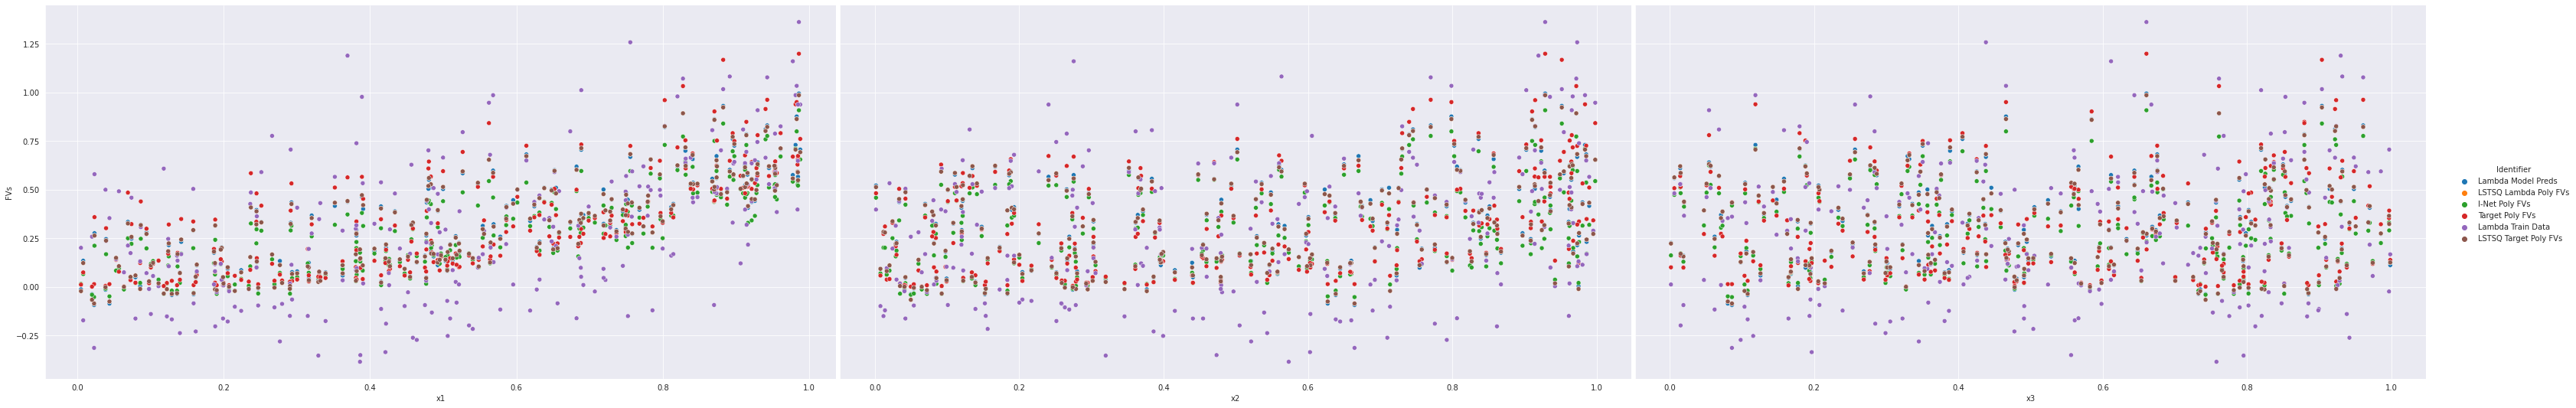

+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|         Comparison        |         MAE          |      R2-Score      | Poly 1 |                       Poly 2                       |
+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|       Lambda Preds        | 0.007689713068709697 | 0.9983565212584861 |   -    |           -1.4958*a**1.0*b**1.0*c**1.0 +           |
|            vs.            |                      |                    |        |           1.1761*a**1.0*b**1.0*c**2.0 +            |
|  LSTSQ Lambda Preds Poly  |                      |                    |        | 0.4353*a**1.0*b**1.0*c**3.0 - 0.4174*a**1.0*b**1.0 |
|                           |                      |                    |        |           + 1.589*a**1.0*b**2.0*c**1.0 -           |
|                           |                   

In [78]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      inet_preds_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

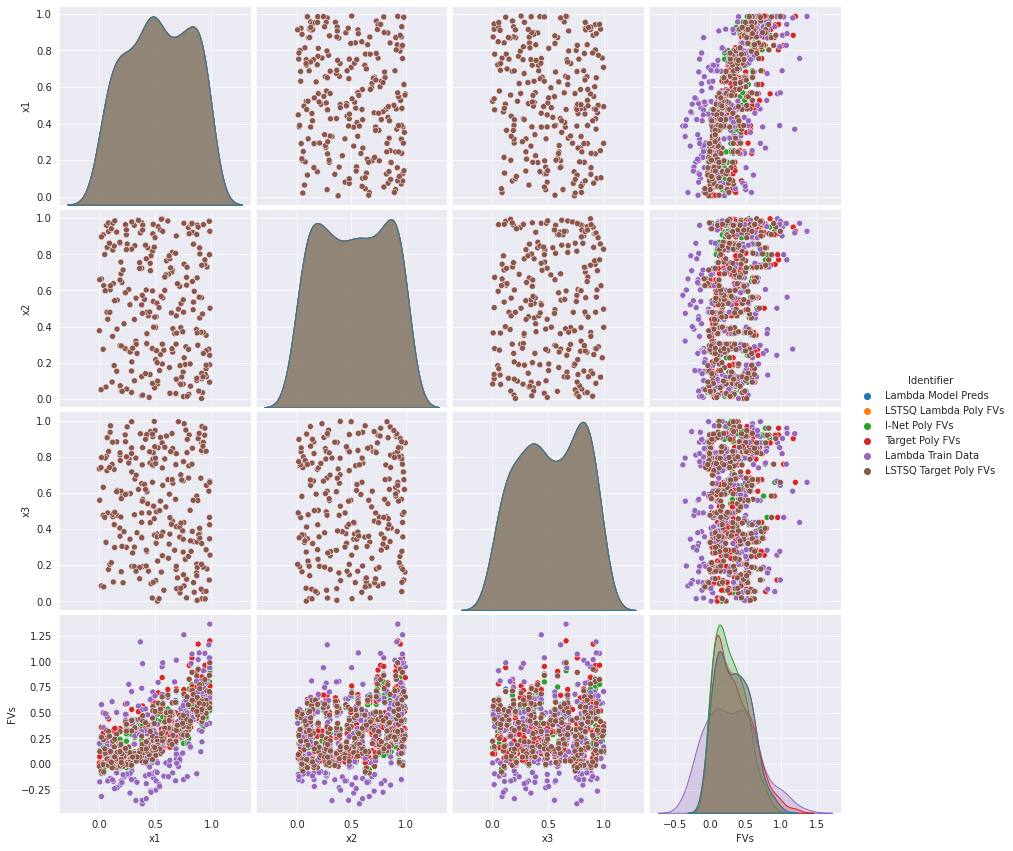

+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|         Comparison        |         MAE          |      R2-Score      | Poly 1 |                       Poly 2                       |
+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|       Lambda Preds        | 0.007689713068709697 | 0.9983565212584861 |   -    |           -1.4958*a**1.0*b**1.0*c**1.0 +           |
|            vs.            |                      |                    |        |           1.1761*a**1.0*b**1.0*c**2.0 +            |
|  LSTSQ Lambda Preds Poly  |                      |                    |        | 0.4353*a**1.0*b**1.0*c**3.0 - 0.4174*a**1.0*b**1.0 |
|                           |                      |                    |        |           + 1.589*a**1.0*b**2.0*c**1.0 -           |
|                           |                   

In [79]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      inet_preds_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

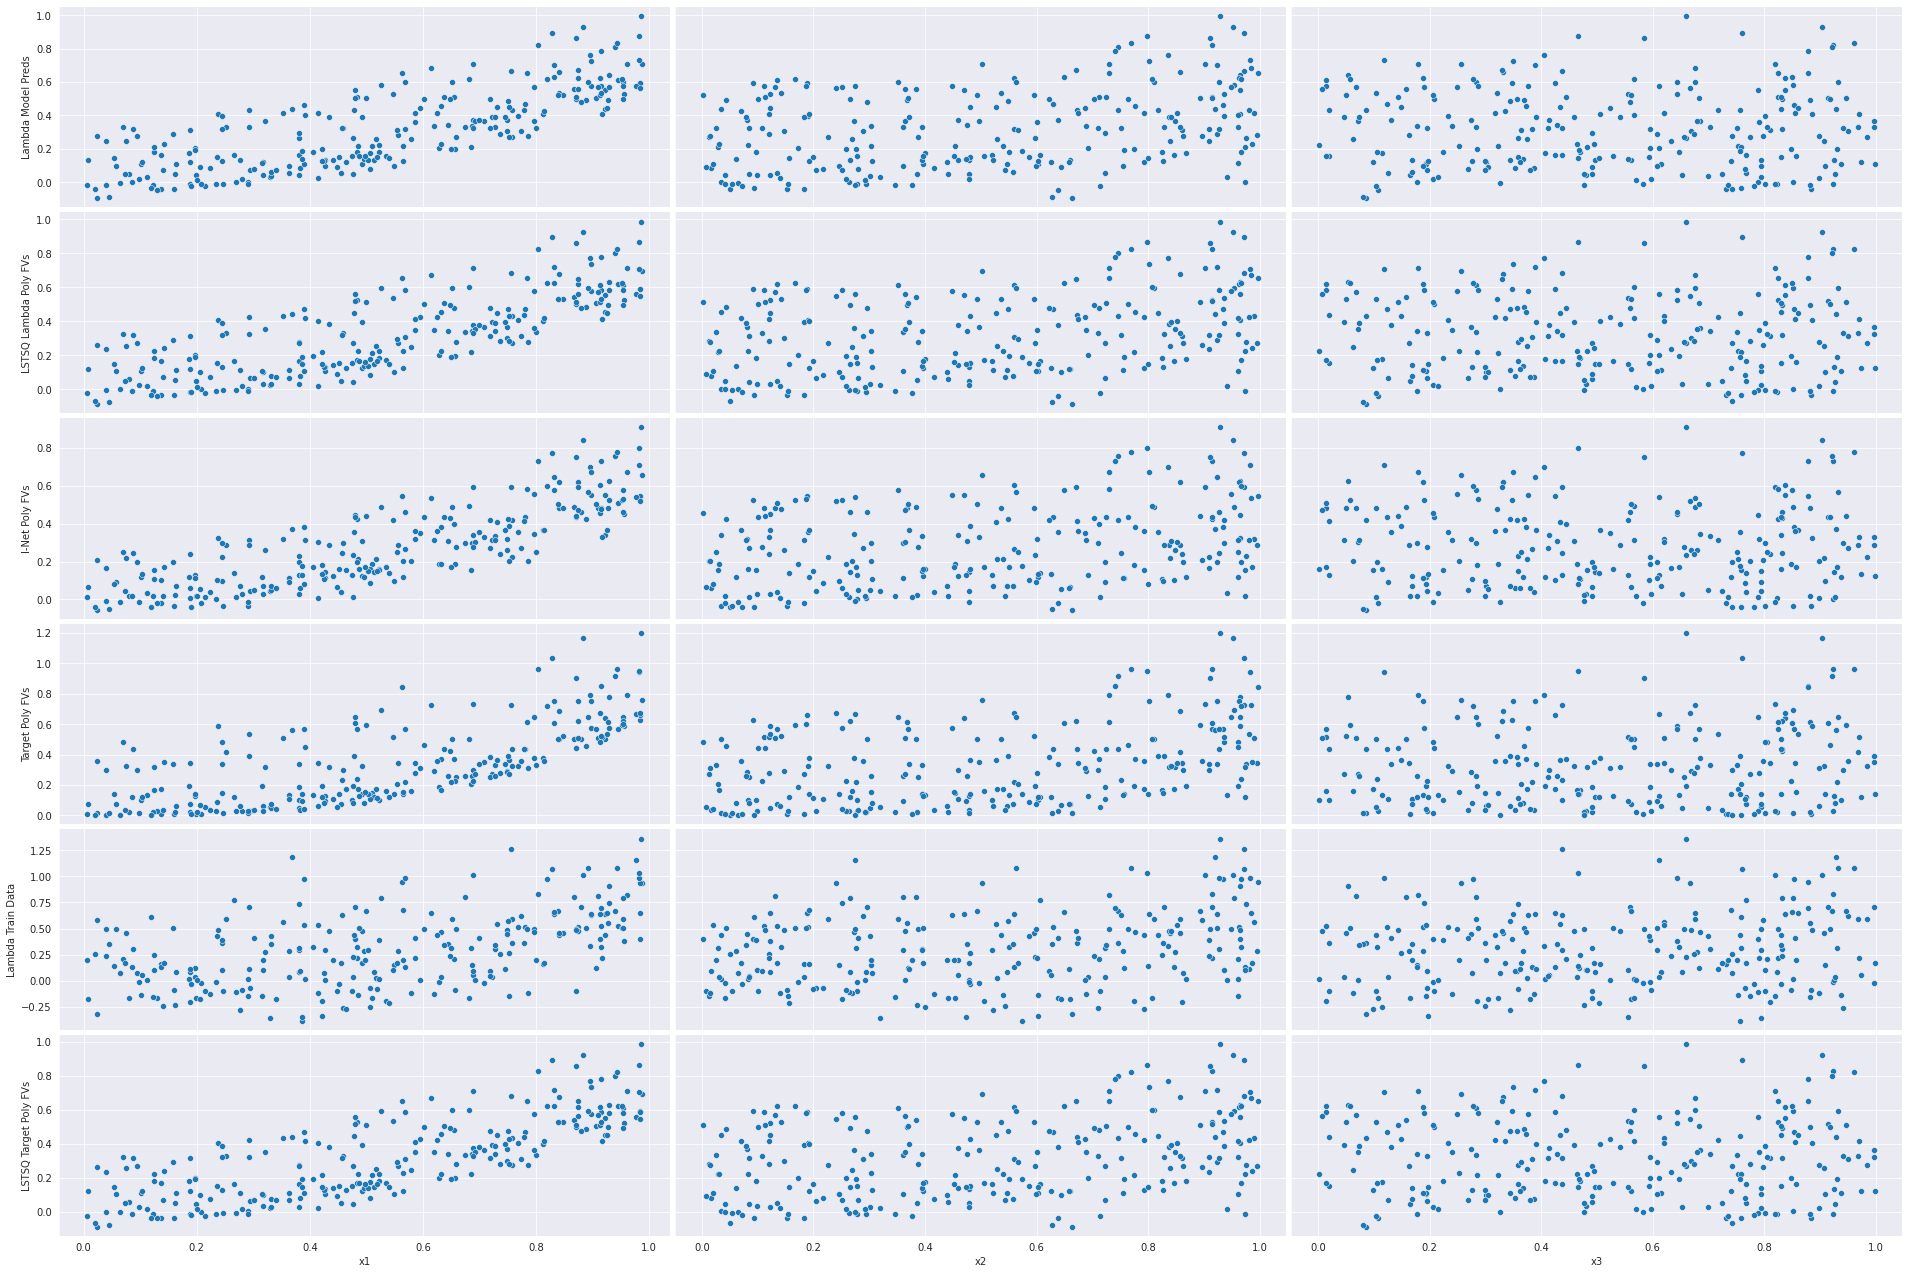

+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|         Comparison        |         MAE          |      R2-Score      | Poly 1 |                       Poly 2                       |
+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|       Lambda Preds        | 0.007689713068709697 | 0.9983565212584861 |   -    |           -1.4958*a**1.0*b**1.0*c**1.0 +           |
|            vs.            |                      |                    |        |           1.1761*a**1.0*b**1.0*c**2.0 +            |
|  LSTSQ Lambda Preds Poly  |                      |                    |        | 0.4353*a**1.0*b**1.0*c**3.0 - 0.4174*a**1.0*b**1.0 |
|                           |                      |                    |        |           + 1.589*a**1.0*b**2.0*c**1.0 -           |
|                           |                   

In [80]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      inet_preds_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

# BENCHMARK (RANDOM GUESS) EVALUATION

In [81]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [83]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

In [84]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

Random Guess Error Coefficients: 4.9984


In [85]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

Random Guess Error FVs: 10.0919


# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [86]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [87]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

Educated Guess/Mean Prediction Error FVs: 0.2705


In [88]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [89]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()